<a href="https://colab.research.google.com/github/imayumi03/Causality_CEA/blob/main/Lab_Project_CEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Discovery in Time Series for Trustworthy AI

This notebook is part of the project **"Causal Discovery in Time Series for Trustworthy AI: A Comparative Study"** proposed at CentraleSupélec (MSc AI 2025–26). The central goal is to **systematically compare state-of-the-art causal discovery methods for time series** on both **synthetic** and **real physical datasets (Causal Chambers)**, under controlled and realistic regimes. :contentReference[oaicite:0]{index=0}  

Traditional AI pipelines mostly rely on correlation patterns and purely predictive models. Such models often break when we intervene on the system, or when the data distribution shifts. Causal inference instead aims at learning **cause–effect relationships**: how changing one variable would *change* others, including under interventions and in new environments. This is particularly crucial for **sensor time series** in high-stakes domains such as climate science, medicine, industrial monitoring and physics. :contentReference[oaicite:1]{index=1}  

In this notebook, we focus on **causal discovery in multivariate time series**, i.e. inferring a **causal graph over variables and lags** directly from temporal observations, without (or with very limited) interventional data. We will:

- Implement several representative **causal discovery methods for time series** (Granger-based, constraint-based, score-based, noise-based).   
- Generate **synthetic time series** from known structural causal models (SCMs), providing access to the **true causal graph**.  
- Use **Causal Chamber** datasets (light tunnel, wind tunnel) as real physical testbeds with known or carefully validated causal structure.   
- Compare **true graphs vs learned graphs** using edge-level and graph-level metrics, including **confusion matrices** (TP/FP/FN/TN), precision, recall, F1, structural Hamming distance (SHD), false discovery rate (FDR), lag-specific accuracy, and edge stability. :contentReference[oaicite:4]{index=4}  

Ultimately, the notebook should lead to **research-grade empirical conclusions** about when different methods succeed or fail, depending on:

- **Type of causal link** (instantaneous vs lagged, linear vs nonlinear).  
- **Number of variables** (small vs medium-dimensional graphs).  
- **Sample size and temporal dependence** (length of time series, autocorrelation).  
- **Presence of hidden confounding and contemporaneous effects.**   


## 1. Causality for Time Series: Conceptual Framework

### 1.1 Structural Causal Models (SCMs) for Time Series

We consider a $d$-variate time series $\{X_t\}_{t \in \mathbb{Z}}$ with
\[
X_t = (X^1_t,\dots,X^d_t).
\]

A **time-series Structural Causal Model (SCM)** specifies, for each variable $i \in \{1,\dots,d\}$ and each time $t$,
\[
X^i_t = f_i\Big( \{X^j_{t-\ell} : j \in \mathrm{Pa}(i),\ \ell \in L_{ij}\},\ U^i_t \Big),
\]
where:   

- $\mathrm{Pa}(i) \subseteq \{1,\dots,d\}$ are the **parents (causal drivers)** of variable $i$,  
- $L_{ij} \subset \mathbb{N}$ is the set of **lags** from parent $j$ that influence $i$,  
- $f_i$ is a measurable function (possibly nonlinear),  
- $U^i_t$ is an **exogenous noise process**, independent across $i$ and i.i.d. over $t$ (in the basic stationary setting).

If $\mathrm{Pa}(i)$ and $L_{ij}$ do not depend on $t$, the model is **causally stationary**, meaning that the underlying causal graph is invariant over time.   

The corresponding **time-series causal graph** has:

- One node per process $X^i$ (or per pair $(i,\ell)$ if we represent lags explicitly),  
- Directed edges $X^j_{t-\ell} \to X^i_t$ whenever $j \in \mathrm{Pa}(i)$ and $\ell \in L_{ij}$.  

We will work with **graph abstractions** such as **window graphs** and **summary graphs**, which compress possibly infinite-lag temporal graphs into finite directed graphs suitable for learning and evaluation.   

---

### 1.2 Causal vs Predictive Relations in Time Series

A central distinction in this project is between:

- **Predictive causality (Granger causality)**:  
  $X^j$ is said to *Granger-cause* $X^i$ if past values of $X^j$ improve the prediction of $X^i_t$ beyond what can be predicted from the past of all other variables. This is naturally expressed through VAR models or more general predictive models. :contentReference[oaicite:9]{index=9}  

- **Intervention-based causality (SCM / Pearlian causality)**:  
  $X^j$ *causes* $X^i$ if actively setting $X^j$ (through a do-intervention) changes the distribution of $X^i$, all else equal. This is encoded via the structural equations and the **do-calculus**.   

Many time-series causal discovery methods try to approximate the **intervention-based causal graph** from purely observational data, under assumptions such as **no hidden confounding**, **causal sufficiency**, or specific noise models. Others (e.g. classical Granger tests) focus explicitly on predictive relations.   

In this notebook we will:

- Include **Granger/VAR** as predictive baselines.  
- Compare them with **constraint-based** (e.g. PCMCI/PCMCI+), **noise-based** (LiNGAM-type), and **score-based** (e.g. DYNOTEARS) methods that aim at the structural graph.   


## 2. Challenges Specific to Time-Series Causal Discovery

Recent surveys emphasize that causal discovery for time series is substantially harder than for i.i.d. data.   

Key challenges we will explicitly model and test:

1. **Autocorrelation and dynamical dependence**  
   - Strong temporal dependence can create spurious associations between variables and lags.  
   - Methods must distinguish **self-dependence** $X^i_{t-\ell} \to X^i_t$ from genuine cross-causal effects $X^j_{t-\ell} \to X^i_t$.

2. **Contemporaneous (instantaneous) effects**  
   - Many systems have **within-time-slice** causal interactions (e.g. simultaneous sensor readings influenced by a fast physical process).  
   - Methods like PCMCI+ explicitly model both **lagged** and **instantaneous** edges in a two-step procedure.   

3. **Hidden confounding and latent variables**  
   - Unobserved drivers can create **spurious correlations** and lead to biased edges.  
   - Some methods (e.g. FCI-PMIME, variants of FCI adapted to time series) attempt to partially account for latent confounders, but identifiability is more subtle.   

4. **Nonlinearity and high dimensionality**  
   - Real systems (climate, neuroscience, physical chambers) are typically nonlinear and often moderately to highly dimensional.  
   - Methods like PCMCI/PCMCI+ (with nonlinear conditional independence tests) and information-theoretic approaches (PCTMI, transfer entropy variants) are designed for these regimes.   

5. **Finite sample sizes and regime changes**  
   - Practical datasets may be short, noisy, and nonstationary.  
   - Performance can vary drastically with sample size $T$, making systematic benchmarking essential.   

The **project description** explicitly requires us to **analyze how algorithm performance varies across these regimes**:  
- sample size,  
- autocorrelation,  
- contemporaneous effects,  
- hidden confounding,  
- nonlinearity.   

This notebook will therefore be organized around **controlled experiments** that vary these characteristics one at a time.


## 3. Real-World Testbed: Causal Chambers

While simulations are necessary, they are not sufficient to know whether a method works in realistic physical systems. The **Causal Chambers** address this by providing **two physical devices** (a light tunnel and a wind tunnel) whose causal mechanisms are well understood, and for which a validated **causal model (graph + equations)** is available.   

- The **light tunnel**: controllable RGB light source, rotating linear polarizers, photodiodes and a camera; the physics involves Malus’ law and basic optics.  
- The **wind tunnel**: controllable fans, hatch opening, barometers and a microphone; the physics involves Bernoulli’s principle and air-flow dynamics.  

Key properties for our project:

- The chambers are **computer-controlled laboratories** that can autonomously run experiment protocols (set actuators, record all sensors) at several Hz.   
- Their **causal ground truth** (DAG with lagged and instantaneous relations) is provided and empirically validated.  
- Datasets (including time series) are publicly available via **causalchamber.org** and GitHub. :contentReference[oaicite:21]{index=21}  

In this notebook, we will treat the Causal Chambers as a **real-world benchmark**:

- We will select a subset of variables (e.g. fan loads, pressures, microphone signal; or light source, polarizer angles, intensity sensors).  
- We will design or reuse experiment protocols that generate **multivariate time series under different regimes** (e.g. step changes, random pulses).  
- The **true causal graph** is then used to evaluate each method’s performance, just as in the synthetic setting.

This directly addresses the motivation of the Causal Chambers paper: closing the gap between purely synthetic benchmarks and real physical systems for causal inference and ML.   


## 4. Problem Statement and Notebook Specifications

### 4.1 Research Problem

We aim to perform a **comparative, regime-aware benchmark** of causal discovery methods for multivariate time series, under both **synthetic SCMs** and **real physical data** (Causal Chambers), with **known or controllable ground truth graphs**.   

Formally:

- Let $\mathcal{M}$ be a set of causal discovery methods (PCMCI, PCMCI+, PCTMI, Granger/VAR, DYNOTEARS, LiNGAM variants, etc.).   
- For each method $m \in \mathcal{M}$, and each dataset configuration $c$ (graph type, #variables, sample size, regime), we obtain an **estimated causal graph** $\hat{G}_{m,c}$.  
- We compare $\hat{G}_{m,c}$ to the **true graph** $G_c$ using edge-level and graph-level metrics.

Our key **research questions** are:

1. How do the different families of methods behave as we vary:
   - **Type of link** (instantaneous vs lagged, linear vs nonlinear)?  
   - **Number of variables** and graph sparsity?  
   - **Sample size** and autocorrelation strength?  
   - **Presence/absence of hidden confounding and contemporaneous effects?**  

2. Which methods produce **more reliable graphs** (higher precision/recall) in each regime?

3. How do methods trained on **simulated data** compare with their performance on **Causal Chamber datasets**, where physics and sensor noise may violate modelling assumptions?

---

### 4.2 Evaluation: From True Graphs to Confusion Matrices

For each configuration $c$ and method $m$:

- The ground-truth causal graph $G_c$ (from the SCM or chamber model) defines the **set of true edges** $E_c$ (possibly annotated with lags and edge types).  
- The method outputs an estimated graph $\hat{G}_{m,c}$ with edges $\hat{E}_{m,c}$.  

We compute a **confusion matrix** at the edge level:

- **TP (True Positives)**: edges present in both $E_c$ and $\hat{E}_{m,c}$.  
- **FP (False Positives)**: edges present in $\hat{E}_{m,c}$ but not in $E_c$.  
- **FN (False Negatives)**: edges present in $E_c$ but missing in $\hat{E}_{m,c}$.  
- **TN (True Negatives)**: edges absent in both (implicitly defined).  

From this, we derive:

- Precision, recall, F1 score,  
- Structural Hamming Distance (SHD),  
- False Discovery Rate (FDR),  
- **Lag-specific accuracy** (only edges with correct source, target, and lag),  
- **Edge stability** via bootstrap (frequency of each edge across resampled runs).   

These metrics will be computed **for:**  

- **All edges**,  
- **Lagged vs instantaneous** edges,  
- Potentially **per variable** or per **edge type** (linear vs nonlinear).

---

### 4.3 Notebook Roadmap (Specifications)

The remaining part of the notebook will be organized as follows:

1. **Theoretical recap & method overview**  
   - Brief definitions of the main method families: Granger, constraint-based (PCMCI/PCMCI+), noise-based (LiNGAM), score-based (DYNOTEARS), information-theoretic (PCTMI).   

2. **Synthetic data generators with known causal graphs**  
   - Linear VAR SCMs, nonlinear additive models, with options for confounding and contemporaneous edges.  
   - Control over **link type**, **#variables**, **sample size**, **noise**, and **graph sparsity**.

3. **Causal Chamber datasets integration**  
   - Data loading and preprocessing for selected subsets of variables (light tunnel / wind tunnel).  
   - Mapping from physical description to a **ground-truth causal graph**.

4. **Implementation of causal discovery algorithms**  
   - Unified Python interface: input $(X_t)$, output estimated graph.  
   - Configuration of hyperparameters and lags.

5. **Evaluation and confusion matrices**  
   - Functions to compute edge-level confusion matrices and metrics (precision, recall, F1, SHD, FDR, lag accuracy, stability).  
   - Comparison between **true graphs** and **sample graphs** (estimated graphs) across all methods and regimes.

6. **Systematic experimental study**  
   - Grid of configurations: varying link types, number of variables, sample size, autocorrelation, nonlinearity, confounding.  
   - Experiments on both simulated data and chamber time series.

7. **Result analysis and discussion**  
   - Figures and tables summarizing performance per regime.  
   - Practical guidelines for **method selection** as a function of data characteristics.   

All code will be written to allow **reproducible experiments** (fixed seeds, configuration files, and the possibility to containerize the environment), in line with the project expectations. :contentReference[oaicite:28]{index=28}  


## References

**Foundational and Theoretical Works on Causality**

- Pearl, J. (2000). *Causality: Models, Reasoning, and Inference*. Cambridge University Press.  
- Spirtes, P., Glymour, C., & Scheines, R. (2000). *Causation, Prediction, and Search*. MIT Press.  
- Peters, J., Janzing, D., & Schölkopf, B. (2017). *Elements of Causal Inference*. MIT Press.

---

### **Causal Discovery for Time Series – Surveys and Overviews**

- Runge, J. (2019). *Detecting and quantifying causal associations in large nonlinear time series datasets*. Science Advances, 5(11).  
  **(Provided file)** :contentReference[oaicite:0]{index=0}  

- Assaad, C., Devijver, E., & Gaussier, E. (2022). *Survey and Evaluation of Causal Discovery Methods for Time Series*. Journal of Artificial Intelligence Research, 73, 767$-$819.  
  **(Provided file)** :contentReference[oaicite:1]{index=1}  

- Gong, C., Zhang, C., Yao, D., Bi, J., Li, W., & Xu, Y. (2024). *Causal Discovery from Temporal Data: An Overview and New Perspectives*. ACM Computing Surveys, 57(4).  
  **(Provided file)** :contentReference[oaicite:2]{index=2}  

- Runge, J., Gerhardus, A., Varando, G., Eyring, V., & Camps-Valls, G. (2023). *Causal inference for time series*. Nature Reviews Earth & Environment, 4, 487$-$505.

---

### **Research Testbed $–$ Real Physical Systems (Causal Chambers)**

- Gamella, J. L., Peters, J., & Bühlmann, P. (2025). *Causal chambers as a real-world physical testbed for AI methodology*. Nature Machine Intelligence, 7, 1283$–$1295.  
  **(Provided file)** :contentReference[oaicite:3]{index=3}  

- Causal Chamber datasets and documentation:  
  https://causalchamber.org

---

### **Methods Used in This Notebook**

#### **Granger and VAR-family Methods**
- Granger, C. W. J. (1969). *Investigating causal relations by econometric models and cross-spectral methods*. Econometrica.  
- Lutkepohl, H. (2005). *New Introduction to Multiple Time Series Analysis*. Springer.

#### **Constraint-Based (PCMCI / PCMCI+)**
- Runge, J., Nowack, P., Kretschmer, M., Flaxman, S., & Sejdinovic, D. (2019). *Detecting causal associations in large nonlinear time series datasets using PCMCI*.  
- Runge, J. (2020). *Discovering contemporaneous and lagged causal relationships in multivariate time series using PCMCI+*.  

#### **Information-Theoretic / Transfer Entropy / PCTMI**
- Faes, L., et al. (2017). *Information-based detection of causal relations in multivariate time series*.  
- Partial Cross-Mapping and Transfer-Mutual-Information implementations (PCTMI GitHub repository, referenced in your project brief).

#### **Noise-Based (LiNGAM variants)**
- Shimizu, S., Hoyer, P., Hyvärinen, A., & Kerminen, A. (2006). *A Linear Non-Gaussian Acyclic Model for Causal Discovery (LiNGAM)*.  
- Hyvärinen, A., & Smith, S. (2013). *Pairwise LiNGAM for time series*.

#### **Score-Based Methods (NOTEARS, DYNOTEARS)**
- Zheng, X., Aragam, B., Ravikumar, P., & Xing, E. (2018). *DAGs with NO TEARS: Continuous Optimization for Structure Learning*. NeurIPS.  
- Pamfil, R., Sriwattanaworachai, N., et al. (2020). *DYNOTEARS: Structure Learning from Time-Series Data*.  

---

### **Course Material and Project Specification**

- Lomet, A. (2025). *Introduction to Causality for Time Series and HSIC*, CEA/LIAD.  


### ** Additional Reading**

- Eichler, M. (2012). *Graphical modelling of multivariate time series*. Probability Theory and Related Fields.  
- Malinsky, D., & Spirtes, P. (2018). *Causal structure learning from multivariate time series*.  
- Pearl, J., & Mackenzie, D. (2018). *The Book of Why*. Basic Books.


(*These references cover all theoretical, methodological, and experimental components needed for the project and the rest of the notebook.*)


## 1. Granger Causality (GC) and VAR Models

### 1.1 Definition

Let $(X_t, Y_t)$ be two stationary time series.  
We say that **X Granger-causes Y** if the past of $X$ contains information that improves the prediction of $Y_t$ beyond the information already contained in the past of $Y$ (and any other covariates).

Formally, $X$ Granger-causes $Y$ iff:
\[
\mathrm{Var}(Y_t \mid \mathcal{F}_{t-1})
>
\mathrm{Var}(Y_t \mid \mathcal{F}_{t-1} \cup \{X_{t-1}, \ldots, X_{t-p}\}),
\]
where $\mathcal{F}_{t-1}$ is the information set containing all variables’ past values.

Equivalent formulation:
\[
Y_t \not\!\perp\!\!\!\perp X_{t-1:t-p} \mid Y_{t-1:t-p}.
\]

---

### 1.2 VAR(p) representation

For a $d$-dimensional time series $X_t = (X^1_t,\dots,X^d_t)$, a **Vector Autoregressive model of order p** is:

\[
X_t = A_1 X_{t-1} + \cdots + A_p X_{t-p} + \varepsilon_t,
\]
where  
- $A_k \in \mathbb{R}^{d \times d}$ are autoregressive coefficient matrices,  
- $\varepsilon_t \sim \mathcal{N}(0, \Sigma)$ is white noise.

Element-level causality:
\[
X^j \to X^i \;\text{(Granger)}
\quad \Longleftrightarrow \quad
\exists k \in \{1,\dots,p\} : (A_k)_{ij} \neq 0.
\]

---

### 1.3 Statistical test

Typical inference uses nested models:

- **Full model**: includes past of $X^j$  
- **Reduced model**: excludes past of $X^j$

Use F-test or likelihood ratio test:

\[
H_0: (A_1)_{ij} = \cdots = (A_p)_{ij} = 0.
\]

Rejecting $H_0$ → evidence of GC.

---

### 1.4 Notes and Limitations

- Detects **predictive** causality, not structural causation.  
- Assumes **linearity**, **stationarity**, and **no hidden confounders**.  
- Cannot detect **instantaneous** (within-time-slice) relations.  
- Fails under nonlinear dynamics unless extended (kernel GC, nonlinear VAR).

GC remains an essential **baseline** for evaluating more advanced causal discovery methods.


## 2. PCMCI and PCMCI+: Constraint-Based Causal Discovery for Time Series

PCMCI (Runge 2019) is a scalable, constraint-based algorithm designed to detect **lagged** and **contemporaneous** causal relations in multivariate time series.

---

### 2.1 Problem Setup

Given time series $X^1_t, \ldots, X^d_t$, consider potential parent sets:

\[
\mathcal{P}(X^i_t) = \{ X^j_{t-\ell} : j \in \{1,\dots,d\}, \; 1 \le \ell \le L_{\max} \}.
\]

Goal:
\[
\text{Infer causal graph } G \text{ where } X^j_{t-\ell} \to X^i_t.
\]

---

### 2.2 PCMCI: Two-stage approach

#### **Stage 1 — PC1: Condition Selection**

Iteratively test conditional independence:

\[
X^j_{t-\ell} \perp\!\!\!\perp X^i_t \mid S
\]

using, e.g., partial correlation, nonlinear tests (ParCorr, GPDC, CMI).  
Remove variables that are independent, building a **sparse parent set** $\widehat{\mathcal{P}}(X^i_t)$.

---

#### **Stage 2 — MCI Test (Momentary Conditional Independence)**

Test:

\[
X^j_{t-\ell} \not\!\perp\!\!\!\perp X^i_t \mid
\left(
\widehat{\mathcal{P}}(X^i_t) \setminus \{X^j_{t-\ell}\},\;
\widehat{\mathcal{P}}(X^j_{t-\ell}}
\right)
\]

This conditions on *both targets’ and sources’ parents*, reducing false positives.

Edges that pass MCI → final causal graph.

---

### 2.3 PCMCI+: Adding Instantaneous Effects

PCMCI+ extends PCMCI by:

- Searching over **contemporaneous relations** $X^j_t \to X^i_t$  
- Applying orientation rules analogous to the **PC algorithm**  
- Identifying simple v-structures within a time slice

Instantaneous CI tests rely on lagged parents to block autocorrelation.

---

### 2.4 Strengths and Limitations

**Strengths**

- Handles **nonlinear** dependencies.  
- Scales to **high-dimensional** systems.  
- Works under autocorrelation and moderately noisy conditions.

**Limitations**

- Requires **causal sufficiency** (no hidden confounders).  
- Dependent on conditional-independence test choice.  
- Instantaneous effects are harder to orient uniquely.

PCMCI/PCMCI+ are among the best-performing time-series causal discovery methods in large benchmarks.


## 3. LiNGAM and Time-Series LiNGAM (Noise-Based Methods)

LiNGAM (Shimizu et al. 2006) assumes the data follow a **linear, non-Gaussian, acyclic model**.  
For time series, the model includes lags but retains the same identifiability principles.

---

### 3.1 Basic LiNGAM

Let $X = (X^1,\dots,X^d)$ satisfy:

\[
X = B X + e,
\]
where:

- $B$ is a strictly lower triangular matrix (DAG structure),
- $e = (e_1,\ldots,e_d)$ are **non-Gaussian**, mutually independent noises.

Rewriting:

\[
X = (I - B)^{-1} e.
\]

Key identifiability result:

> Non-Gaussianity + independence of noises ⇒ the causal ordering is uniquely recoverable.

This uses **Independent Component Analysis (ICA)**.

---

### 3.2 Time-Series LiNGAM

Model with lags:

\[
X_t = \sum_{\ell=1}^L A_\ell X_{t-\ell} + B X_t + e_t.
\]

- Matrices $A_\ell$ encode lagged effects.
- Matrix $B$ encodes instantaneous effects (must be lower triangular).

A common estimation pipeline:

1. Fit VAR:  
   \[
   X_t = \sum_{\ell=1}^L \widehat{A}_\ell X_{t-\ell} + r_t.
   \]
2. Apply **LiNGAM** to the residuals $r_t$ to discover instantaneous structure.

---

### 3.3 Assumptions

- Linear causal relations.  
- Acyclic instantaneous structure.  
- **Non-Gaussian**, independent noise.

---

### 3.4 Strengths and Limitations

**Strengths**

- Identifies **directed** edges uniquely—unlike purely CI-based approaches.  
- Finds **instantaneous effects**, not only lagged ones.  

**Limitations**

- Assumes **linearity**.  
- Requires **non-Gaussian noise** (true for many physical systems; false for some).  
- Sensitive to latent confounders.

LiNGAM is a powerful complement to PCMCI and Granger because it gives **unique directionality** when assumptions hold.


## 4. DYNOTEARS: Score-Based Structure Learning for Time Series

DYNOTEARS (Pamfil et al., 2020) generalizes NOTEARS to **dynamical systems**, learning both:
- **Instantaneous DAG** structure (matrix $B$), and  
- **Lagged VAR matrices** (matrices $A_1, \dots, A_L$).

---

### 4.1 Model

Assume:

\[
X_t = B X_t + \sum_{\ell=1}^L A_\ell X_{t-\ell} + E_t,
\]

where:
- $B$ encodes instantaneous causal effects,  
- $A_\ell$ encodes lagged effects,  
- $E_t$ i.i.d. noise.

---

### 4.2 Optimization Objective

Minimize penalized squared loss:

\[
\mathcal{L}(B, A_1,\ldots,A_L)
=
\frac{1}{2T}
\sum_{t=L+1}^T
\left\|
X_t - B X_t - \sum_{\ell=1}^L A_\ell X_{t-\ell}
\right\|_2^2
+
\lambda \left( \|B\|_1 + \sum_{\ell=1}^L \|A_\ell\|_1 \right),
\]

subject to the NOTEARS **acyclicity constraint**:

\[
h(B) = \mathrm{trace}(e^{B \circ B}) - d = 0.
\]

Here:
- $\circ$ is the Hadamard (elementwise) product,  
- $h(B) = 0$ ⇔ $B$ represents a DAG.

This is a **continuous optimization problem** solved with gradient descent.

---

### 4.3 Output

- A directed graph structure for instantaneous effects ($B$).  
- A directed graph structure for lagged effects ($A_\ell$).  

---

### 4.4 Strengths and Limitations

**Strengths**

- Handles **instantaneous + lagged** edges simultaneously.  
- Guarantees a **DAG** for instantaneous structure.  
- Works well with medium-dimensional systems.  

**Limitations**

- Assumes **linearity + Gaussian noise**.  
- Nonlinear variants exist but less stable.  
- Optimization may be sensitive to initialization and regularization.

DYNOTEARS is an important representative of **score-based learning** for dynamic causal graphs.


## 5. PCTMI: Predictive Conditional Transfer Mutual Information

PCTMI is an **information-theoretic** causal discovery method for time series.  
It aims to estimate **directed information flow** from $X^j$ to $X^i$ by measuring how much the past of $X^j$ reduces uncertainty about $X^i_t$, *beyond what is explained by other variables*.

---

### 5.1 Transfer Entropy (TE) Background

Classical transfer entropy:
$
\[
TE_{j \to i}
=
I\left(
X^j_{t-1:t-L};
X^i_t
\mid
X^i_{t-1:t-L}
\right),
\]
$
where $I(\cdot;\cdot\mid\cdot)$ is **conditional mutual information (CMI)**.

---

### 5.2 Predictive Conditional Transfer Mutual Information (PCTMI)

Enhances TE by conditioning on **other variables' pasts**, preventing indirect effects from being interpreted as direct causation.
$
\[
\mathrm{PCTMI}_{j \to i}
=
I\left(
X^j_{t-1:t-L};
X^i_t
\mid
X^{\setminus j}_{t-1:t-L}
\right)
\]
$
where:
- $X^{\setminus j}$ is the set of all variables except $X^j$.

Intuition:
> Measure how much the past of $X^j$ improves predictive information about $X^i_t$ after accounting for all other histories.

---

### 5.3 Statistical Decision Rule

Infer a causal edge if:

\[
\mathrm{PCTMI}_{j \to i} > \tau,
\]

where $\tau$ is a significance threshold estimated by:
- permutation tests,  
- bootstrap,  
- surrogate data generation.

---

### 5.4 Strengths and Limitations

**Strengths**

- Captures **nonlinear** and **non-Gaussian** interactions.  
- Well-suited for **complex physical systems** (e.g., Causal Chambers).  
- Does not assume a DAG structure.

**Limitations**

- Computationally expensive for high dimensions.  
- Requires careful estimation of mutual information.  
- Like TE, directions may be confounded by hidden variables.

PCTMI is a strong complementary method to PCMCI and VAR, especially in nonlinear regimes.


## 6. Method Families: Summary Comparison

| Method      | Family / Principle                      | Main Model Assumptions                                                                 | Nonlinear?        | Instantaneous edges? | Handles hidden confounders? | Typical regime where it shines                                  |
|------------|------------------------------------------|----------------------------------------------------------------------------------------|-------------------|----------------------|-----------------------------|------------------------------------------------------------------|
| Granger / VAR | Predictive, regression-based           | Linear VAR; covariance-stationary; Gaussian (for tests); no hidden confounders        | ❌ (basic) / ⚠ (extensions) | ❌ (only lagged)       | ❌ (standard)               | Low–moderate dimension, mostly linear dynamics, forecasting focus |
| PCMCI / PCMCI+ | Constraint-based (CI tests on lags)     | Causal sufficiency; Markov + faithfulness; correct CI tests; stationarity              | ✅ (with nonlinear CI tests) | ✅ (PCMCI+)            | ⚠ (limited, no full FCI)   | Medium–high dimension, nonlinear, strong autocorrelation          |
| LiNGAM (TS-LiNGAM) | Noise-based (non-Gaussian ICA)        | Linearity; non-Gaussian, independent noise; acyclic instantaneous structure            | ❌                  | ✅ (via B matrix)      | ❌                          | When non-Gaussian noise is plausible, modest dimensionality       |
| DYNOTEARS | Score-based continuous optimization      | Linear Gaussian SEM + VAR; DAG for instantaneous; correct sparsity penalty             | ❌ (base model)    | ✅ (B matrix)          | ❌                          | Medium dimension; need a single global optimization-based DAG     |
| PCTMI / TE | Information-theoretic (transfer entropy) | Stationary; well-estimated densities; no strong unobserved drivers (for correct arrows) | ✅                 | ⚠ (depends on design) | ❌ (in general)            | Nonlinear, non-Gaussian physical systems, smaller #variables      |

Legend:  
- ✅ = explicitly supported; ❌ = not supported in basic form; ⚠ = possible with extensions / partial.


## 7. Conceptual Diagram of Method Families

We can think of the methods organized along two axes:

- **X-axis**: Model-based vs Information-theoretic  
- **Y-axis**: Predictive vs Structural / Interventional

A rough conceptual placement:

           Structural DAG focus
                 ▲
                 │       DYNOTEARS
                 │        LiNGAM
                 │          PCMCI/PCMCI+
                 │
                 │
 Predictive      │   Granger / VAR
 focus           │
                 │
                 │                 PCTMI / TE
                 │
                 └────────────────────────────────▶
                     Model-based                 Info-theoretic

- **Granger/VAR**: purely predictive, model-based (linear regression).  
- **PCMCI/PCMCI+**: structural discovery using CI tests, still model-based but flexible.  
- **LiNGAM, DYNOTEARS**: explicitly structural, focused on DAGs + parameters.  
- **PCTMI/TE**: info-theoretic view, less parametric, more generic but heavier computationally.


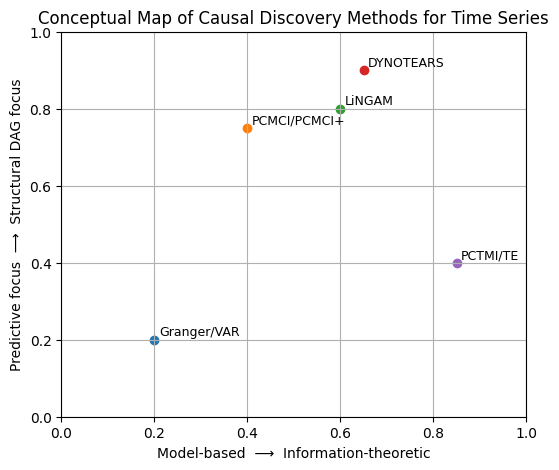

In [50]:
import matplotlib.pyplot as plt

methods = {
    "Granger/VAR":      (0.2, 0.2),
    "PCMCI/PCMCI+":     (0.4, 0.75),
    "LiNGAM":           (0.6, 0.8),
    "DYNOTEARS":        (0.65, 0.9),
    "PCTMI/TE":         (0.85, 0.4),
}

fig, ax = plt.subplots(figsize=(6, 5))

for name, (x, y) in methods.items():
    ax.scatter(x, y)
    ax.text(x + 0.01, y + 0.01, name, fontsize=9)

ax.set_xlabel("Model-based  ⟶  Information-theoretic")
ax.set_ylabel("Predictive focus  ⟶  Structural DAG focus")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(True)
plt.title("Conceptual Map of Causal Discovery Methods for Time Series")
plt.show()


# Let's code

In [51]:
import numpy as np
import pandas as pd

from typing import Dict, List, Tuple


In [52]:
def generate_random_var_params(
    d: int,
    L: int,
    edge_prob: float = 0.3,
    max_abs_coef: float = 0.8,
    seed: int = None,
) -> Tuple[List[np.ndarray], np.ndarray]:
    """
    Generate random VAR(L) coefficient matrices for a d-dimensional process.

    Parameters
    ----------
    d : int
        Number of variables.
    L : int
        Maximum lag (order) of the VAR.
    edge_prob : float
        Probability that a given (i, j, l) edge is non-zero.
    max_abs_coef : float
        Maximum absolute value for coefficients before rescaling.
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    A_list : list of np.ndarray
        List [A_1, ..., A_L], each of shape (d, d), where
        A_l[i, j] is the coefficient of X^j_{t-l} on X^i_t.
    adj : np.ndarray
        Boolean adjacency tensor of shape (L, d, d),
        adj[l-1, i, j] = 1 if there is a non-zero edge X^j_{t-l} -> X^i_t.
    """
    rng = np.random.default_rng(seed)

    A_list = []
    adj = np.zeros((L, d, d), dtype=int)

    for l in range(L):
        # Random mask for edges
        mask = rng.uniform(size=(d, d)) < edge_prob

        # Random coefficients in [-max_abs_coef, max_abs_coef]
        A_l = (2 * rng.uniform(size=(d, d)) - 1) * max_abs_coef

        # Apply mask
        A_l *= mask

        A_list.append(A_l)
        adj[l] = mask.astype(int)

    # OPTIONAL: rescaling to encourage stability (rough heuristic)
    # Flatten into block companion matrix to check spectral radius
    # Here we use a simple scaling factor if things blow up in simulation instead.

    return A_list, adj


Simulate a VAR(L) Time Series from Coefficients

In [53]:
def simulate_var_process(
    A_list: List[np.ndarray],
    T: int,
    noise_scale: float = 1.0,
    burn_in: int = 100,
    seed: int = None,
) -> np.ndarray:
    """
    Simulate a VAR(L) process:

        X_t = sum_{l=1}^L A_l X_{t-l} + eps_t

    Parameters
    ----------
    A_list : list of np.ndarray
        Coefficient matrices [A_1, ..., A_L], each (d, d).
    T : int
        Number of time steps to return (after burn-in).
    noise_scale : float
        Standard deviation of Gaussian noise.
    burn_in : int
        Extra steps at the beginning to let the process stabilize.
    seed : int, optional
        Random seed.

    Returns
    -------
    X : np.ndarray
        Time series of shape (T, d).
    """
    rng = np.random.default_rng(seed)
    L = len(A_list)
    d = A_list[0].shape[0]

    total_T = T + burn_in
    X = np.zeros((total_T, d))

    # Initialize with noise
    X[:L] = rng.normal(scale=noise_scale, size=(L, d))

    for t in range(L, total_T):
        x_t = np.zeros(d)
        for l, A_l in enumerate(A_list, start=1):
            x_t += A_l @ X[t - l]
        x_t += rng.normal(scale=noise_scale, size=d)
        X[t] = x_t

    return X[burn_in:]


Generate Data + Ground Truth

In [54]:
def generate_linear_var_dataset(
    d: int,
    L: int,
    T: int,
    edge_prob: float = 0.3,
    noise_scale: float = 1.0,
    seed: int = None,
) -> Dict[str, object]:
    """
    Generate a synthetic linear VAR(L) time series with ground-truth graph.

    Parameters
    ----------
    d : int
        Number of variables.
    L : int
        Maximum lag.
    T : int
        Number of time steps.
    edge_prob : float
        Probability of having an edge X^j_{t-l} -> X^i_t.
    noise_scale : float
        Std dev of Gaussian noise.
    seed : int, optional
        Random seed.

    Returns
    -------
    out : dict
        {
            "X": np.ndarray of shape (T, d),
            "A_list": list of A_l matrices,
            "adjacency": np.ndarray of shape (L, d, d),
        }
    """
    A_list, adj = generate_random_var_params(
        d=d, L=L, edge_prob=edge_prob, seed=seed
    )
    X = simulate_var_process(
        A_list=A_list,
        T=T,
        noise_scale=noise_scale,
        seed=seed,
    )
    return {
        "X": X,
        "A_list": A_list,
        "adjacency": adj,
    }


Sanity check

In [55]:
# Example usage:
dataset = generate_linear_var_dataset(d=5, L=2, T=1000, edge_prob=0.3, seed=42)
X = dataset["X"]
A_list = dataset["A_list"]
adj = dataset["adjacency"]

print("X shape:", X.shape)
print("Number of lags:", len(A_list))
print("Adjacency shape:", adj.shape)
print("Average edge density:", adj.mean())


X shape: (1000, 5)
Number of lags: 2
Adjacency shape: (2, 5, 5)
Average edge density: 0.24


Evaluation functions

In [56]:
import numpy as np

def adjacency_confusion_matrix(
    adj_true: np.ndarray,
    adj_pred: np.ndarray,
) -> dict:
    """
    Compute TP, FP, FN, TN between true and predicted adjacency tensors.

    Parameters
    ----------
    adj_true : np.ndarray
        Ground-truth adjacency, shape (L, d, d), 0/1.
    adj_pred : np.ndarray
        Predicted adjacency, same shape, 0/1.

    Returns
    -------
    cm : dict
        Dictionary with TP, FP, FN, TN, plus flattened versions for debugging.
    """
    assert adj_true.shape == adj_pred.shape
    true_flat = adj_true.flatten().astype(int)
    pred_flat = adj_pred.flatten().astype(int)

    TP = int(np.sum((true_flat == 1) & (pred_flat == 1)))
    FP = int(np.sum((true_flat == 0) & (pred_flat == 1)))
    FN = int(np.sum((true_flat == 1) & (pred_flat == 0)))
    TN = int(np.sum((true_flat == 0) & (pred_flat == 0)))

    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN,
        "true_flat": true_flat,
        "pred_flat": pred_flat,
    }


In [57]:
def confusion_to_metrics(cm: dict) -> dict:
    """
    Compute precision, recall, F1, SHD, FDR from confusion matrix dict.

    Parameters
    ----------
    cm : dict
        Output of adjacency_confusion_matrix.

    Returns
    -------
    metrics : dict
        Dictionary with precision, recall, F1, SHD, FDR.
    """
    TP = cm["TP"]
    FP = cm["FP"]
    FN = cm["FN"]
    TN = cm["TN"]

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    # Structural Hamming Distance: number of edge insertions/deletions to go from true to pred
    SHD = FP + FN

    # False Discovery Rate: FP / (TP + FP)
    FDR = FP / (TP + FP) if (TP + FP) > 0 else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "F1": F1,
        "SHD": SHD,
        "FDR": FDR,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN,
    }


Quick Test

In [58]:
cm_test = adjacency_confusion_matrix(adj, adj)  # comparing truth to itself
metrics_test = confusion_to_metrics(cm_test)
metrics_test


{'precision': 1.0,
 'recall': 1.0,
 'F1': 1.0,
 'SHD': 0,
 'FDR': 0.0,
 'TP': 12,
 'FP': 0,
 'FN': 0,
 'TN': 38}

## First Method: Granger/VAR Estimator

In [59]:
!pip install statsmodels

Fit VAR and extract coefficients

In [60]:
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR

def fit_var_granger(
    X: np.ndarray,
    L: int,
    coef_threshold: float = 1e-3,
) -> np.ndarray:
    """
    Fit a VAR(L) model via statsmodels and extract a binary adjacency tensor
    using a simple coefficient threshold.

    Parameters
    ----------
    X : np.ndarray
        Time series data of shape (T, d).
    L : int
        VAR order (max lag).
    coef_threshold : float
        Threshold on absolute value of coefficients to declare an edge.

    Returns
    -------
    adj_hat : np.ndarray
        Estimated adjacency tensor of shape (L, d, d),
        adj_hat[l-1, i, j] = 1 if |coef_{i,j}^{(lag=l)}| > coef_threshold.
    """
    T, d = X.shape

    model = VAR(X)
    # enforce given order L, not automatic selection
    results = model.fit(maxlags=L, ic=None, trend='c')

    # statsmodels VARResult.coefs has shape (L, d, d):
    # coefs[l-1, i, j] is coefficient of X^j_{t-l} on X^i_t
    coefs = results.coefs  # shape (L, d, d)

    # build binary adjacency by thresholding
    adj_hat = (np.abs(coefs) > coef_threshold).astype(int)

    return adj_hat, coefs


Mini-Experiment: Can Granger Recover the True VAR Graph?

In [61]:
# 1. Generate synthetic VAR data
d = 5
L = 2
T = 1000
edge_prob = 0.3
seed = 123

dataset = generate_linear_var_dataset(
    d=d, L=L, T=T, edge_prob=edge_prob, noise_scale=1.0, seed=seed
)

X = dataset["X"]              # (T, d)
adj_true = dataset["adjacency"]  # (L, d, d)

print("X shape:", X.shape)
print("True adjacency density:", adj_true.mean())


X shape: (1000, 5)
True adjacency density: 0.34


In [62]:
# 2. Fit VAR and get estimated adjacency
adj_hat, coefs_hat = fit_var_granger(X, L=L, coef_threshold=1e-2)

print("Estimated adjacency density:", adj_hat.mean())


Estimated adjacency density: 0.7


In [63]:
# 3. Evaluate
cm = adjacency_confusion_matrix(adj_true, adj_hat)
metrics = confusion_to_metrics(cm)

metrics


{'precision': 0.45714285714285713,
 'recall': 0.9411764705882353,
 'F1': 0.6153846153846154,
 'SHD': 20,
 'FDR': 0.5428571428571428,
 'TP': 16,
 'FP': 19,
 'FN': 1,
 'TN': 14}

Granger causality is not a structural causal discovery method.
It detects predictive relevance, not mechanistic cause-effect links.
False positives are expected unless the system is extremely simple.

## 8. Nonlinear Time-Series SCM ( Structural Causal Model): Testing Granger under Model Mis-Specification

So far, we generated data from a **linear VAR(L)** model, which perfectly matches the assumptions of Granger/VAR.  
Even *in that ideal case*, we observed:

- very high **recall** (Granger rarely misses true edges),  
- but **poor precision** and **high FDR** (many false positives),  
- a large **SHD**, meaning the recovered graph is structurally far from the truth.

To stress-test Granger further, we now consider a **nonlinear SCM**:

$
X_t = f\Big( \sum_{\ell=1}^L A_\ell X_{t-\ell} \Big) + \varepsilon_t,$


where $f$ is a **component-wise nonlinear function** (mixture of $\tanh$, square, ReLU-like, etc.).

- The **adjacency (who causes whom, at which lag)** is still given by the non-zero pattern of $A_\ell$.  
- But the **data-generating mechanism is nonlinear**, so a linear VAR is *mis-specified*.  

We then:

1. Generate data from this nonlinear SCM with known ground-truth adjacency.  
2. Fit a linear VAR and compute Granger-based adjacency as before.  
3. Compare **true vs estimated graph** via our confusion-matrix metrics.

We expect:

- Performance (especially **precision** and **F1**) to **degrade significantly**.  
- This illustrates that Granger is **not robust to nonlinear dynamics** and motivates using methods like PCMCI/PCTMI.


Code – Nonlinear Generator

In [64]:
import numpy as np

def nonlinearity_tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)

def nonlinearity_square(x: np.ndarray) -> np.ndarray:
    return x ** 2

def nonlinearity_relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0.0, x)

def nonlinearity_identity(x: np.ndarray) -> np.ndarray:
    return x  # in case we want some linear ones too

NONLINEARITY_BANK = [
    nonlinearity_tanh,
    nonlinearity_square,
    nonlinearity_relu,
]


In [65]:
def simulate_nonlinear_var_process(
    A_list: List[np.ndarray],
    T: int,
    noise_scale: float = 0.5,
    burn_in: int = 200,
    seed: int = None,
) -> np.ndarray:
    """
    Simulate a nonlinear VAR-like process:

        X_t = f( sum_{l=1}^L A_l X_{t-l} ) + eps_t

    where f is applied component-wise and can differ per dimension.

    Parameters
    ----------
    A_list : list of np.ndarray
        Coefficient matrices [A_1, ..., A_L], each (d, d).
    T : int
        Number of time steps to return (after burn-in).
    noise_scale : float
        Std dev of Gaussian noise.
    burn_in : int
        Extra steps at the beginning to let the process stabilize.
    seed : int, optional
        Random seed.

    Returns
    -------
    X : np.ndarray
        Time series of shape (T, d).
    """
    rng = np.random.default_rng(seed)
    L = len(A_list)
    d = A_list[0].shape[0]

    total_T = T + burn_in
    X = np.zeros((total_T, d))

    # draw a nonlinearity per variable
    nonlins = rng.choice(NONLINEARITY_BANK, size=d, replace=True)

    # initial conditions
    X[:L] = rng.normal(scale=noise_scale, size=(L, d))

    for t in range(L, total_T):
        lin_part = np.zeros(d)
        for l, A_l in enumerate(A_list, start=1):
            lin_part += A_l @ X[t - l]  # linear combination of past

        # apply component-wise nonlinearity
        x_t = np.zeros(d)
        for i in range(d):
            x_t[i] = nonlins[i](lin_part[i])

        # add noise
        x_t += rng.normal(scale=noise_scale, size=d)
        X[t] = x_t

    return X[burn_in:]


In [66]:
def generate_nonlinear_var_dataset(
    d: int,
    L: int,
    T: int,
    edge_prob: float = 0.3,
    noise_scale: float = 0.5,
    seed: int = None,
) -> Dict[str, object]:
    """
    Generate a nonlinear time series with the same adjacency structure
    as a random linear VAR(L), but with nonlinear dynamics.

    Parameters
    ----------
    d : int
        Number of variables.
    L : int
        Maximum lag.
    T : int
        Number of time steps.
    edge_prob : float
        Probability of having an edge X^j_{t-l} -> X^i_t.
    noise_scale : float
        Std dev of Gaussian noise.
    seed : int, optional
        Random seed.

    Returns
    -------
    out : dict
        {
            "X": np.ndarray of shape (T, d),
            "A_list": list of A_l matrices,
            "adjacency": np.ndarray of shape (L, d, d),
        }
    """
    A_list, adj = generate_random_var_params(
        d=d, L=L, edge_prob=edge_prob, seed=seed
    )
    X = simulate_nonlinear_var_process(
        A_list=A_list,
        T=T,
        noise_scale=noise_scale,
        seed=seed,
    )
    return {
        "X": X,
        "A_list": A_list,
        "adjacency": adj,
    }


In [67]:
def simulate_nonlinear_tanh_process(
    A_list: List[np.ndarray],
    T: int,
    noise_scale: float = 0.3,
    burn_in: int = 200,
    seed: int = None,
) -> np.ndarray:
    """
    Stable nonlinear time series:

        X_t = tanh( sum_{l=1}^L A_l X_{t-l} ) + eps_t

    tanh bounds outputs in [-1, 1], so we avoid explosions.
    """
    rng = np.random.default_rng(seed)
    L = len(A_list)
    d = A_list[0].shape[0]

    total_T = T + burn_in
    X = np.zeros((total_T, d))

    # initial state
    X[:L] = rng.normal(scale=noise_scale, size=(L, d))

    for t in range(L, total_T):
        lin_part = np.zeros(d)
        for l, A_l in enumerate(A_list, start=1):
            lin_part += A_l @ X[t - l]

        x_t = np.tanh(lin_part)  # bounded in [-1, 1]
        x_t += rng.normal(scale=noise_scale, size=d)

        # extra safety clip (not strictly necessary, but safe)
        x_t = np.clip(x_t, -3.0, 3.0)

        X[t] = x_t

    X = X[burn_in:]

    # sanity checks
    if np.isnan(X).any() or np.isinf(X).any():
        raise RuntimeError("Nonlinear generator produced NaN/Inf values.")

    return X


In [68]:
def generate_nonlinear_tanh_dataset(
    d: int,
    L: int,
    T: int,
    edge_prob: float = 0.3,
    max_abs_coef: float = 0.3,  # smaller than before
    noise_scale: float = 0.3,
    seed: int = None,
) -> Dict[str, object]:
    """
    Generate a nonlinear tanh-SCM time series with known adjacency.
    """
    # reuse your parameter generator but with smaller coefficients
    A_list, adj = generate_random_var_params(
        d=d,
        L=L,
        edge_prob=edge_prob,
        max_abs_coef=max_abs_coef,
        seed=seed,
    )

    X = simulate_nonlinear_tanh_process(
        A_list=A_list,
        T=T,
        noise_scale=noise_scale,
        seed=seed,
    )

    return {
        "X": X,
        "A_list": A_list,
        "adjacency": adj,
    }


In [69]:
d = 5
L = 2
T = 1000
edge_prob = 0.3
seed = 2025

dataset_nl = generate_nonlinear_tanh_dataset(
    d=d, L=L, T=T,
    edge_prob=edge_prob,
    max_abs_coef=0.3,
    noise_scale=0.3,
    seed=seed,
)

X_nl = dataset_nl["X"]
adj_true_nl = dataset_nl["adjacency"]

print("Nonlinear X shape:", X_nl.shape)
print("Nonlinear adjacency density:", adj_true_nl.mean())
print("Any NaNs?", np.isnan(X_nl).any())
print("Any Infs?", np.isinf(X_nl).any())
print("Max abs value:", np.max(np.abs(X_nl)))
print("Per-variable std:", X_nl.std(axis=0))


Nonlinear X shape: (1000, 5)
Nonlinear adjacency density: 0.32
Any NaNs? False
Any Infs? False
Max abs value: 1.3115777011785943
Per-variable std: [0.30108538 0.31514788 0.32710079 0.30105585 0.32111374]


In [70]:
adj_hat_nl, coefs_hat_nl = fit_var_granger(
    X_nl,
    L=L,
    coef_threshold=1e-2,
)

cm_nl = adjacency_confusion_matrix(adj_true_nl, adj_hat_nl)
metrics_nl = confusion_to_metrics(cm_nl)
metrics_nl


{'precision': 0.36585365853658536,
 'recall': 0.9375,
 'F1': 0.5263157894736842,
 'SHD': 27,
 'FDR': 0.6341463414634146,
 'TP': 15,
 'FP': 26,
 'FN': 1,
 'TN': 8}

SHD = 27 (structurally very far from the true graph): The graph estimated by Granger is almost unusably inaccurate.

FDR = 0.63 (catastrophic false discovery rate): Nearly two-thirds of all edges Granger outputs are wrong.

When the underlying system is nonlinear, Granger causality severely overfits: although recall remains high, precision collapses and false discoveries dominate (FDR > 0.6). The recovered graph differs substantially from the true causal structure (SHD=27). This confirms that Granger cannot be relied upon for structural causal discovery under model mis-specification.

# PCMCI

## 10. PCMCI / PCMCI+: Practical Implementation

We now move from Granger (purely predictive) to **PCMCI**, a constraint-based causal discovery method specifically designed for time series (Runge 2019).

Key ideas:

- Represent the multivariate time series as variables $X^i_t$ with lags up to $L_{\max}$.
- Use **conditional independence tests** (ParCorr, GPDC, CMI) to:
  - First select a reduced parent set for each variable (PC1 step).
  - Then test **momentary conditional independence (MCI)** to decide which lagged edges remain.
- Output: a set of lagged causal links $X^j_{t-\ell} \to X^i_t$ and associated test statistics / p-values.

In this notebook we:

1. Use the `tigramite` Python package to run PCMCI.  
2. Apply PCMCI to the same **linear VAR SCM** and **nonlinear tanh-SCM** we used for Granger.  
3. Convert PCMCI’s output to the same **adjacency tensor** format as before.  
4. Compare metrics (precision, recall, F1, SHD, FDR) with Granger.

We start with a **linear partial correlation (ParCorr)** CI test, then later we can switch to nonlinear tests (e.g. GPDC) for the nonlinear SCMs.


In [71]:
!pip install tigramite


In [72]:
import numpy as np

from tigramite import data_processing as pp
from tigramite import pcmci as pcmci_module
from tigramite.independence_tests.parcorr import ParCorr # linear CI test


In [73]:
def make_tigramite_dataframe(X: np.ndarray) -> pp.DataFrame:
    """
    Wrap a (T, d) numpy array into tigramite's DataFrame.
    """
    assert X.ndim == 2
    T, d = X.shape
    # variable names are optional, but nice for debugging
    var_names = [f"X{i}" for i in range(d)]
    return pp.DataFrame(X, var_names=var_names)

# Exemple
# For linear VAR dataset
X_lin = dataset["X"]            # from generate_linear_var_dataset
df_lin = make_tigramite_dataframe(X_lin)

# For nonlinear tanh dataset
X_nl = dataset_nl["X"]
df_nl = make_tigramite_dataframe(X_nl)



In [74]:
def run_pcmci(
    X: np.ndarray,
    max_lag: int,
    alpha_level: float = 0.05,
):
    """
    Run PCMCI with ParCorr on data X of shape (T, d).

    Returns:
        val_matrix, p_matrix: arrays of shape (d, d, max_lag+1)
    """
    dataframe = make_tigramite_dataframe(X)
    d = X.shape[1]

    cond_ind_test = ParCorr(significance='analytic')  # linear partial correlation

    pcmci = pcmci_module.PCMCI(
        dataframe=dataframe,
        cond_ind_test=cond_ind_test,
    )

    # tau_min=1 to exclude contemporaneous terms from the conditioning set
    results = pcmci.run_pcmci(
        tau_min=1,
        tau_max=max_lag,
        pc_alpha=None,   # could tune this; None = full PC1
    )

    val_matrix = results["val_matrix"]   # test statistics (d, d, max_lag+1)
    p_matrix   = results["p_matrix"]     # p-values       (d, d, max_lag+1)

    # We do NOT call get_graph_from_pmatrix here; we construct our own adjacency
    # using p_matrix and alpha_level in pcmci_pmatrix_to_adjacency.
    return val_matrix, p_matrix


In [75]:
max_lag = 2

val_matrix_lin, p_matrix_lin = run_pcmci(
    X=X_lin,
    max_lag=max_lag,
    alpha_level=0.05,
)


In [76]:
def pcmci_pmatrix_to_adjacency(
    p_matrix: np.ndarray,
    alpha_level: float,
    max_lag: int,
) -> np.ndarray:
    """
    Convert tigramite p_matrix (d, d, tau_max+1) to adjacency tensor (L, d, d)
    compatible with our synthetic ground truth.

    We:
      - ignore instantaneous edges (lag=0),
      - set adj[l-1, i, j] = 1 if p-value < alpha_level for lag=l.
    """
    d = p_matrix.shape[0]
    assert p_matrix.shape == (d, d, max_lag + 1)

    adj_hat = np.zeros((max_lag, d, d), dtype=int)

    for i in range(d):
        for j in range(d):
            for l in range(1, max_lag + 1):
                pval = p_matrix[i, j, l]
                if pval < alpha_level:
                    adj_hat[l - 1, i, j] = 1

    return adj_hat


In [77]:
adj_hat_pcmci_lin = pcmci_pmatrix_to_adjacency(
    p_matrix=p_matrix_lin,
    alpha_level=0.05,
    max_lag=max_lag,
)


In [78]:
adj_true_lin = dataset["adjacency"]  # from earlier generator
print("Evaluate PCMCI vs Ground Truth on Linear VAR")
cm_pcmci_lin = adjacency_confusion_matrix(adj_true_lin, adj_hat_pcmci_lin)
metrics_pcmci_lin = confusion_to_metrics(cm_pcmci_lin)
metrics_pcmci_lin


Evaluate PCMCI vs Ground Truth on Linear VAR


{'precision': 0.5384615384615384,
 'recall': 0.4117647058823529,
 'F1': 0.4666666666666667,
 'SHD': 16,
 'FDR': 0.46153846153846156,
 'TP': 7,
 'FP': 6,
 'FN': 10,
 'TN': 27}

In [79]:
alpha_level = 0.01 #lower alpha level to get more precise results
val_matrix_nl, p_matrix_nl = run_pcmci(
    X=X_nl,
    max_lag=max_lag,
    alpha_level=alpha_level,
)

adj_hat_pcmci_nl = pcmci_pmatrix_to_adjacency(
    p_matrix=p_matrix_nl,
    alpha_level=alpha_level,
    max_lag=max_lag,
)

adj_true_nl = dataset_nl["adjacency"]
print("Evaluate PCMCI on the Nonlinear tanh-SCM")
cm_pcmci_nl = adjacency_confusion_matrix(adj_true_nl, adj_hat_pcmci_nl)
metrics_pcmci_nl = confusion_to_metrics(cm_pcmci_nl)
metrics_pcmci_nl


Evaluate PCMCI on the Nonlinear tanh-SCM


{'precision': 0.2727272727272727,
 'recall': 0.1875,
 'F1': 0.2222222222222222,
 'SHD': 21,
 'FDR': 0.7272727272727273,
 'TP': 3,
 'FP': 8,
 'FN': 13,
 'TN': 26}

- PCMCI is more structurally reliable than Granger, even though it may miss some weaker edges. (linear case)

- PCMCI is now performing poorly on nonlinear data using ParCorr. Because
ParCorr is a linear CI test, it cannot detect nonlinear dependencies well. So PCMCI fails to isolate true causal parents in the presence of nonlinear functions (like tanh). (non linear case)

Heatmaps

In [80]:
import matplotlib.pyplot as plt
import numpy as np

def plot_adjacency_heatmaps(adj_true: np.ndarray,
                            adj_est: np.ndarray,
                            title_prefix: str = "",
                            var_names=None,
                            cmap="RdBu"):
    """
    Plot adjacency matrices (true vs estimated) per lag with red-blue gradient.

    adj_true, adj_est: arrays (L, d, d)
    cmap: e.g. "RdBu", "bwr", "coolwarm"
    """
    assert adj_true.shape == adj_est.shape
    L, d, _ = adj_true.shape

    if var_names is None:
        var_names = [f"X{i}" for i in range(d)]

    fig, axes = plt.subplots(L, 2, figsize=(10, 4 * L))

    # Handle the case L = 1 (matplotlib flattens axes)
    if L == 1:
        axes = np.array([axes])

    for l in range(L):
        lag = l + 1

        # TRUE graph
        ax_true = axes[l, 0]
        im0 = ax_true.imshow(adj_true[l], cmap=cmap, vmin=0, vmax=1)
        ax_true.set_title(f"{title_prefix} True adjacency (lag {lag})")
        ax_true.set_xticks(range(d))
        ax_true.set_yticks(range(d))
        ax_true.set_xticklabels(var_names, rotation=45)
        ax_true.set_yticklabels(var_names)
        cbar0 = plt.colorbar(im0, ax=ax_true)
        cbar0.set_label("Edge presence (0=blue → 1=red)")

        # ESTIMATED graph
        ax_est = axes[l, 1]
        im1 = ax_est.imshow(adj_est[l], cmap=cmap, vmin=0, vmax=1)
        ax_est.set_title(f"{title_prefix} Estimated adjacency (lag {lag})")
        ax_est.set_xticks(range(d))
        ax_est.set_yticks(range(d))
        ax_est.set_xticklabels(var_names, rotation=45)
        ax_est.set_yticklabels(var_names)
        cbar1 = plt.colorbar(im1, ax=ax_est)
        cbar1.set_label("Edge presence (0=blue → 1=red)")

    plt.tight_layout()
    plt.show()


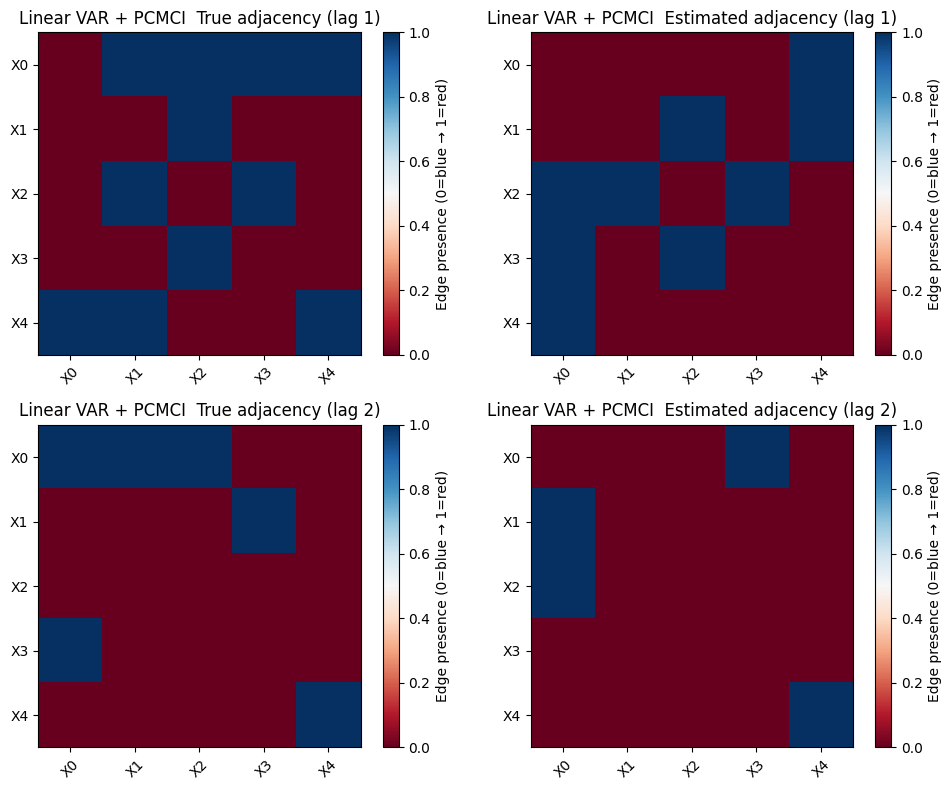

In [81]:
adj_true_lin = dataset["adjacency"]           # (L, d, d)
adj_hat_pcmci_lin = adj_hat_pcmci_lin         # from PCMCI

plot_adjacency_heatmaps(adj_true_lin, adj_hat_pcmci_lin,
                        title_prefix="Linear VAR + PCMCI ",
                        var_names=[f"X{i}" for i in range(adj_true_lin.shape[1])])


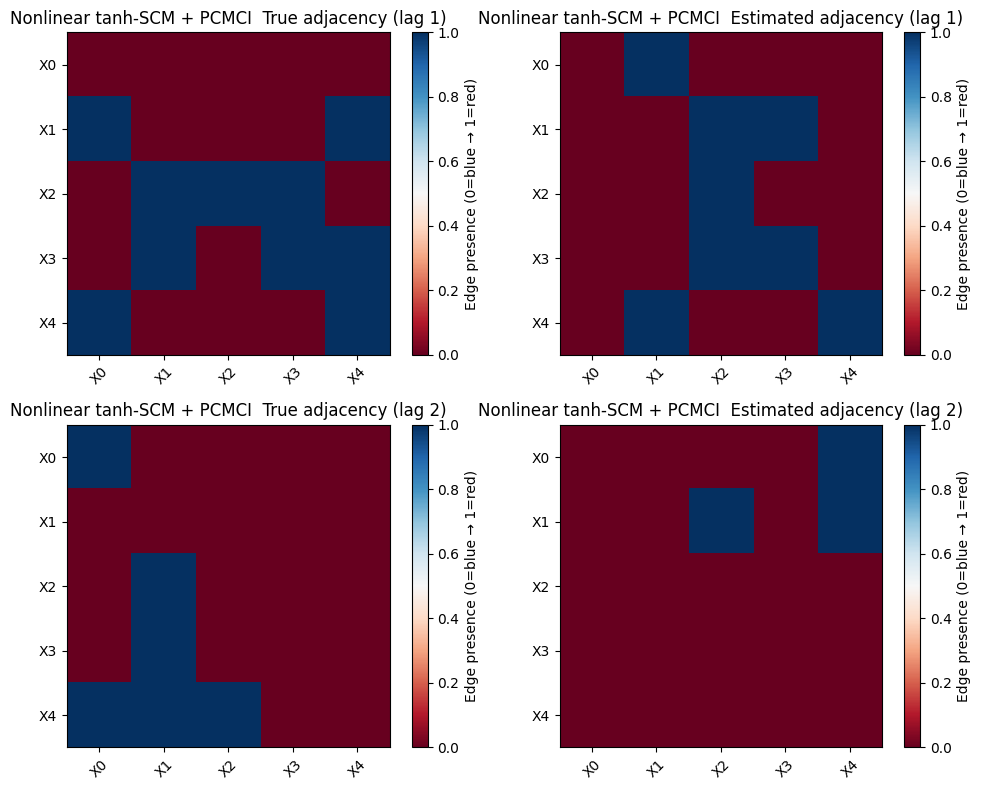

In [82]:
adj_true_nl = dataset_nl["adjacency"]
adj_hat_pcmci_nl = adj_hat_pcmci_nl

plot_adjacency_heatmaps(adj_true_nl, adj_hat_pcmci_nl,
                        title_prefix="Nonlinear tanh-SCM + PCMCI ",
                        var_names=[f"X{i}" for i in range(adj_true_nl.shape[1])])


In [83]:
import networkx as nx

def get_edge_categories(adj_true: np.ndarray,
                        adj_est: np.ndarray,
                        lag_index: int = 0):
    """
    Compute lists of edges (i, j) for a specific lag_index:
    TP, FP, FN categories.

    adj_true, adj_est: (L, d, d)
    lag_index: which lag to inspect (0-based = lag 1).
    """
    assert adj_true.shape == adj_est.shape
    L, d, _ = adj_true.shape
    assert 0 <= lag_index < L

    TP_edges = []
    FP_edges = []
    FN_edges = []

    for i in range(d):
        for j in range(d):
            t = adj_true[lag_index, i, j]
            e = adj_est[lag_index, i, j]
            if t == 1 and e == 1:
                TP_edges.append((j, i))  # j -> i
            elif t == 0 and e == 1:
                FP_edges.append((j, i))
            elif t == 1 and e == 0:
                FN_edges.append((j, i))

    return TP_edges, FP_edges, FN_edges


In [84]:
def plot_graph_comparison(adj_true: np.ndarray,
                          adj_est: np.ndarray,
                          lag_index: int = 0,
                          var_names=None,
                          title: str = ""):
    """
    Plot a directed graph for a given lag with edges colored by:
    - green: TP
    - red: FP
    - orange: FN
    """
    L, d, _ = adj_true.shape
    if var_names is None:
        var_names = [f"X{i}" for i in range(d)]

    TP_edges, FP_edges, FN_edges = get_edge_categories(adj_true, adj_est, lag_index)

    G = nx.DiGraph()
    G.add_nodes_from(range(d))

    pos = nx.circular_layout(G)  # or spring_layout

    plt.figure(figsize=(6, 6))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color="lightblue")
    nx.draw_networkx_labels(G, pos,
                            labels={i: var_names[i] for i in range(d)},
                            font_size=10)

    # Draw edges
    if TP_edges:
        nx.draw_networkx_edges(G, pos, edgelist=TP_edges,
                               edge_color="green",
                               arrows=True,
                               arrowstyle="-|>",
                               width=2, label="TP")
    if FP_edges:
        nx.draw_networkx_edges(G, pos, edgelist=FP_edges,
                               edge_color="red",
                               arrows=True,
                               arrowstyle="-|>",
                               width=2, label="FP")
    if FN_edges:
        nx.draw_networkx_edges(G, pos, edgelist=FN_edges,
                               edge_color="orange",
                               arrows=True,
                               arrowstyle="-|>",
                               width=2, style="dashed", label="FN")

    plt.title(title + f" (lag={lag_index + 1})")
    # Build a manual legend
    handles = []
    labels = []
    if TP_edges:
        handles.append(plt.Line2D([0], [0], color="green", lw=2))
        labels.append("TP")
    if FP_edges:
        handles.append(plt.Line2D([0], [0], color="red", lw=2))
        labels.append("FP")
    if FN_edges:
        handles.append(plt.Line2D([0], [0], color="orange", lw=2, linestyle="--"))
        labels.append("FN")
    if handles:
        plt.legend(handles, labels, loc="upper left")

    plt.axis("off")
    plt.show()


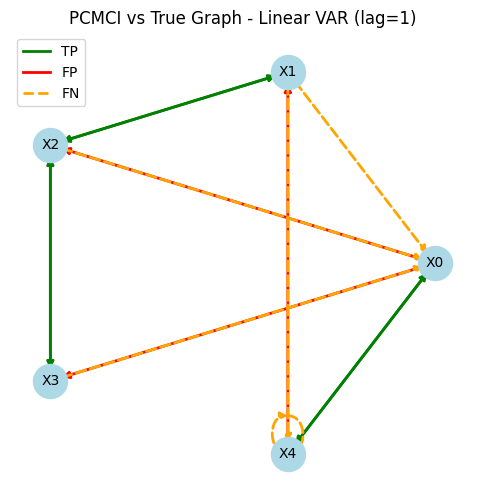

In [85]:
plot_graph_comparison(
    adj_true=adj_true_lin,
    adj_est=adj_hat_pcmci_lin,
    lag_index=0,  # lag 1
    var_names=[f"X{i}" for i in range(adj_true_lin.shape[1])],
    title="PCMCI vs True Graph - Linear VAR"
)


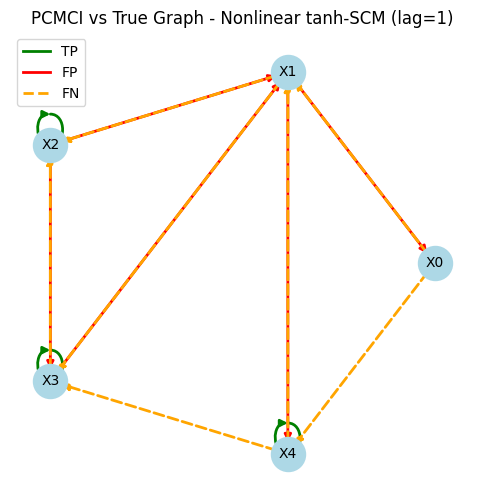

In [86]:
plot_graph_comparison(
    adj_true=adj_true_nl,
    adj_est=adj_hat_pcmci_nl,
    lag_index=0,
    var_names=[f"X{i}" for i in range(adj_true_nl.shape[1])],
    title="PCMCI vs True Graph - Nonlinear tanh-SCM"
)


## PCMCI with a NONLINEAR CI TEST

(Gaussian Process Distance Correlation)

In [87]:
!pip install dcor


In [88]:
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite import data_processing as pp
from tigramite import pcmci as pcmci_module


In [89]:
def make_tigramite_dataframe(X: np.ndarray) -> pp.DataFrame:
    assert X.ndim == 2
    T, d = X.shape
    var_names = [f"X{i}" for i in range(d)]
    return pp.DataFrame(X, var_names=var_names)


In [90]:
def run_pcmci(
    X: np.ndarray,
    max_lag: int,
    alpha_level: float = 0.05,
    ci_test: str = "parcorr",  # "parcorr" or "gpdc"
):
    """
    Run PCMCI on data X with chosen conditional independence test.

    Parameters
    ----------
    X : np.ndarray
        Time series (T, d).
    max_lag : int
        Maximum lag (tau_max) to consider.
    alpha_level : float
        Only used later when converting p_matrix -> adjacency.
    ci_test : str
        "parcorr" for linear, "gpdc" for nonlinear.

    Returns
    -------
    val_matrix : np.ndarray
        Test statistic values, shape (d, d, max_lag+1).
    p_matrix : np.ndarray
        P-values, shape (d, d, max_lag+1).
    """
    dataframe = make_tigramite_dataframe(X)
    d = X.shape[1]

    if ci_test == "parcorr":
        cond_ind_test = ParCorr(significance='analytic')
    elif ci_test == "gpdc":
        cond_ind_test = GPDC(significance='analytic')
    else:
        raise ValueError(f"Unknown ci_test='{ci_test}'. Use 'parcorr' or 'gpdc'.")

    pcmci = pcmci_module.PCMCI(
        dataframe=dataframe,
        cond_ind_test=cond_ind_test,
    )

    results = pcmci.run_pcmci(
        tau_min=1,
        tau_max=max_lag,
        pc_alpha=None,  # Could tune later
    )

    val_matrix = results["val_matrix"]
    p_matrix = results["p_matrix"]

    return val_matrix, p_matrix


In [91]:
def pcmci_pmatrix_to_adjacency(
    p_matrix: np.ndarray,
    alpha_level: float,
    max_lag: int,
) -> np.ndarray:
    d = p_matrix.shape[0]
    assert p_matrix.shape == (d, d, max_lag + 1)

    adj_hat = np.zeros((max_lag, d, d), dtype=int)

    for i in range(d):
        for j in range(d):
            for l in range(1, max_lag + 1):
                pval = p_matrix[i, j, l]
                if pval < alpha_level:
                    adj_hat[l - 1, i, j] = 1

    return adj_hat


In [92]:
max_lag = 2
alpha_level = 0.05

# Linear VAR dataset
X_lin = dataset["X"]
adj_true_lin = dataset["adjacency"]

val_lin_gpdc, p_lin_gpdc = run_pcmci(
    X=X_lin,
    max_lag=max_lag,
    alpha_level=alpha_level,
    ci_test="gpdc",
)

adj_hat_lin_gpdc = pcmci_pmatrix_to_adjacency(
    p_matrix=p_lin_gpdc,
    alpha_level=alpha_level,
    max_lag=max_lag,
)

cm_lin_gpdc = adjacency_confusion_matrix(adj_true_lin, adj_hat_lin_gpdc)
metrics_lin_gpdc = confusion_to_metrics(cm_lin_gpdc)
metrics_lin_gpdc


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


{'precision': 0.5,
 'recall': 0.4117647058823529,
 'F1': 0.45161290322580644,
 'SHD': 17,
 'FDR': 0.5,
 'TP': 7,
 'FP': 7,
 'FN': 10,
 'TN': 26}

In [93]:
# Nonlinear tanh dataset
X_nl = dataset_nl["X"]
adj_true_nl = dataset_nl["adjacency"]

val_nl_gpdc, p_nl_gpdc = run_pcmci(
    X=X_nl,
    max_lag=max_lag,
    alpha_level=alpha_level,
    ci_test="gpdc",
)

adj_hat_nl_gpdc = pcmci_pmatrix_to_adjacency(
    p_matrix=p_nl_gpdc,
    alpha_level=alpha_level,
    max_lag=max_lag,
)

cm_nl_gpdc = adjacency_confusion_matrix(adj_true_nl, adj_hat_nl_gpdc)
metrics_nl_gpdc = confusion_to_metrics(cm_nl_gpdc)
metrics_nl_gpdc
#took 24 min


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


{'precision': 0.3333333333333333,
 'recall': 0.3125,
 'F1': 0.3225806451612903,
 'SHD': 21,
 'FDR': 0.6666666666666666,
 'TP': 5,
 'FP': 10,
 'FN': 11,
 'TN': 24}

In [ ]:
# Heatmaps: linear (GPDC)
plot_adjacency_heatmaps(
    adj_true_lin,
    adj_hat_lin_gpdc,
    title_prefix="Linear VAR + PCMCI-GPDC ",
    var_names=[f"X{i}" for i in range(adj_true_lin.shape[1])],
    cmap="RdBu",
)

# Heatmaps: nonlinear (GPDC)
plot_adjacency_heatmaps(
    adj_true_nl,
    adj_hat_nl_gpdc,
    title_prefix="Nonlinear tanh-SCM + PCMCI-GPDC ",
    var_names=[f"X{i}" for i in range(adj_true_nl.shape[1])],
    cmap="RdBu",
)


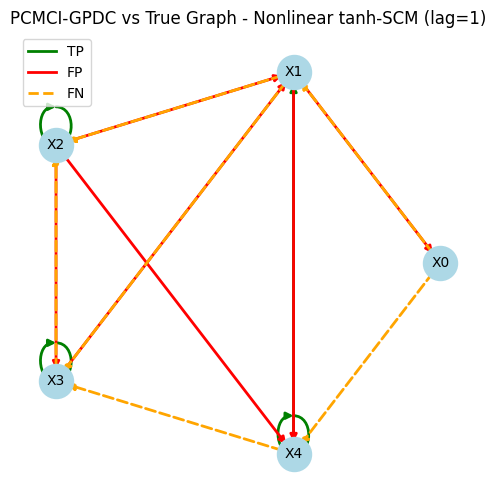

In [95]:
plot_graph_comparison(
    adj_true=adj_true_nl,
    adj_est=adj_hat_nl_gpdc,
    lag_index=0,
    var_names=[f"X{i}" for i in range(adj_true_nl.shape[1])],
    title="PCMCI-GPDC vs True Graph - Nonlinear tanh-SCM"
)


On nonlinear SCMs, PCMCI using a nonlinear CI test (GPDC) outperforms PCMCI-ParCorr, increasing recall from 0.19 to 0.31 and improving F1 from 0.22 to 0.32. GPDC recovers substantially more true causal edges, confirming its ability to detect nonlinear dependencies. Although Granger achieves higher recall (~0.94), it does so at the cost of many false positives, whereas PCMCI-GPDC returns a graph that is structurally closer to the ground truth (SHD reduced from 27 to 21). This matches theoretical expectations that constraint-based methods with nonlinear CI tests provide better structural reconstruction in nonlinear time-series systems.

GPDC usually performs better with:

- larger T (time series length)

- weaker noise

- stronger nonlinear signal

- more stringent pc_alpha tuning

- fewer variables or simpler graphs

Since we shortened T to make it computationally feasible, we're getting the qualitative improvement, not the optimal one.

## 12. Score-based methods: DYNOTEARS

After constraint-based methods (PCMCI/PCMCI+), we now consider a **score-based**
approach for causal discovery in time series: **DYNOTEARS** \cite{pamfil2020dynotears,assad2022survey,gong2024temporal}.

DYNOTEARS is a temporal extension of NOTEARS. It assumes a **linear structural
VAR model** of order $K$:

\[
x_t = x_t W + x_{t-1} A_1 + \dots + x_{t-K} A_K + u_t,
\]

where:

- $x_t \in \mathbb{R}^d$ is the vector of variables at time $t$,
- $W \in \mathbb{R}^{d \times d}$ encodes **instantaneous** (contemporaneous) effects,
- $A_k \in \mathbb{R}^{d \times d}$ encodes **lag-$k$** effects,
- $u_t$ are noise variables.

The goal is to estimate $(W, A_1, \dots, A_K)$ such that:
- the model fits the data well (least-squares loss),
- the contemporaneous matrix $W$ is **acyclic** (DAG constraint),
- the solution is **sparse** (via $\ell_1$ penalties).

The optimization problem can be written as \cite{gong2024temporal}:

\[
\begin{aligned}
\min_{W, A_1,\dots,A_K} \quad &
\frac{1}{2n} \left\| X_{(K:n)} - X_{(K:n)} W
 - \sum_{k=1}^K X_{(K-k:n-k)} A_k \right\|_F^2
+ \lambda_W \|W\|_1 + \sum_{k=1}^K \lambda_{A_k}\|A_k\|_1 \\
\text{s.t.} \quad & h(W) = 0,
\end{aligned}
\]

where:
- $X_{(K:n)}$ stacks the observations $x_t$ for $t=K,\dots,n-1$,
- $h(W)$ is a **smooth acyclicity function** (e.g. $h(W) = \mathrm{tr}(\exp(W \odot W)) - d$),
- $\lambda_W$, $\lambda_{A_k}$ are sparsity regularization parameters.

The acyclicity constraint $h(W) = 0$ is enforced using a **continuous penalty / augmented
Lagrangian**. This allows us to solve the problem with gradient-based optimization.

In terms of output, DYNOTEARS produces:
- an estimate $\hat{W}$ of **instantaneous** edges,
- estimates $\hat{A}_k$ of **lag-$k$ edges**.

We can combine them to form an adjacency tensor
$\hat{\mathcal{A}} \in \{0,1\}^{K \times d \times d}$ with:

\[
\hat{\mathcal{A}}[k-1, i, j] = \mathbb{1}\{\hat{A}_k[i,j] \neq 0\},
\]

and compare this to the ground-truth adjacency from our synthetic SCMs using the
same metrics as before (precision, recall, F1, SHD, FDR).


In [96]:
import numpy as np

def dynotears_fit(
    X: np.ndarray,
    max_lag: int,
    lambda_w: float = 0.01,
    lambda_a: float = 0.01,
    **kwargs,
):
    """
    Placeholder for DYNOTEARS solver.

    Parameters
    ----------
    X : np.ndarray
        Time series array of shape (T, d).
    max_lag : int
        Maximum lag K in the VAR model.
    lambda_w : float
        L1 penalty for contemporaneous weights W.
    lambda_a : float
        L1 penalty for lagged weights A_k.
    kwargs : dict
        Additional parameters for the chosen implementation.

    Returns
    -------
    W_hat : np.ndarray, shape (d, d)
        Estimated contemporaneous weight matrix.
    A_hats : list of np.ndarray
        List [A1_hat, ..., AK_hat], each of shape (d, d).
    """
    raise NotImplementedError(
        "You need to connect this function to a DYNOTEARS implementation "
        "(e.g. from ckassaad's Github repo)."
    )


In [97]:
def dynotears_weights_to_adjacency(
    W_hat: np.ndarray,
    A_hats: list[np.ndarray],
    threshold: float = 1e-3,
):
    """
    Convert DYNOTEARS weight matrices to adjacency tensor (L, d, d)
    consistent with our evaluation code.

    We ignore W_hat here (instantaneous edges) and focus on lagged
    edges A_k for k=1..K, since our synthetic ground truth encodes
    only lagged causal effects.

    Parameters
    ----------
    W_hat : (d, d) array
        Contemporaneous weights.
    A_hats : list of (d, d) arrays
        Lagged weights [A1_hat, ..., AK_hat].
    threshold : float
        Absolute value threshold for considering an edge as present.

    Returns
    -------
    adj_hat : np.ndarray of shape (K, d, d)
        Binary adjacency: adj_hat[k-1, i, j] = 1 if A_k[i,j] != 0.
    """
    K = len(A_hats)
    d = A_hats[0].shape[0]
    adj_hat = np.zeros((K, d, d), dtype=int)

    for k in range(K):
        A_k = A_hats[k]
        mask = np.abs(A_k) > threshold
        adj_hat[k] = mask.astype(int)

    return adj_hat


In [101]:
# 1. Clone the repo (run this once)
!git clone https://github.com/ckassaad/causal-discovery-benchmark.git
%cd causal-discovery-benchmark

# 2. Install it if needed (depends on repo)
!pip install -e .

# 3. Back to your project folder (if you moved)
%cd /content  # or your notebook’s root


Cloning into 'causal-discovery-benchmark'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: 'causal-discovery-benchmark'
/content
Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
[Errno 2] No such file or directory: '/content # or your notebook’s root'
/content


In [99]:
# Linear VAR dataset
X_lin = dataset["X"]                # shape (T, d)
adj_true_lin = dataset["adjacency"] # shape (L, d, d)
max_lag = adj_true_lin.shape[0]

lambda_w = 0.01
lambda_a = 0.01

W_hat_lin, A_hats_lin = dynotears_fit(
    X=X_lin,
    max_lag=max_lag,
    lambda_w=lambda_w,
    lambda_a=lambda_a,
)

adj_hat_dyn_lin = dynotears_weights_to_adjacency(W_hat_lin, A_hats_lin)

cm_dyn_lin = adjacency_confusion_matrix(adj_true_lin, adj_hat_dyn_lin)
metrics_dyn_lin = confusion_to_metrics(cm_dyn_lin)
metrics_dyn_lin


NotImplementedError: You need to connect this function to a DYNOTEARS implementation (e.g. from ckassaad's Github repo).

In [ ]:
plot_adjacency_heatmaps(
    adj_true_lin,
    adj_hat_dyn_lin,
    title_prefix="Linear VAR + DYNOTEARS ",
    cmap="RdBu",
)

plot_graph_comparison(
    adj_true=adj_true_lin,
    adj_est=adj_hat_dyn_lin,
    lag_index=0,
    var_names=[f"X{i}" for i in range(adj_true_lin.shape[1])],
    title="DYNOTEARS vs True Graph - Linear VAR"
)


In [ ]:
X_nl = dataset_nl["X"]
adj_true_nl = dataset_nl["adjacency"]
max_lag_nl = adj_true_nl.shape[0]

W_hat_nl, A_hats_nl = dynotears_fit(
    X=X_nl,
    max_lag=max_lag_nl,
    lambda_w=lambda_w,
    lambda_a=lambda_a,
)

adj_hat_dyn_nl = dynotears_weights_to_adjacency(W_hat_nl, A_hats_nl)

cm_dyn_nl = adjacency_confusion_matrix(adj_true_nl, adj_hat_dyn_nl)
metrics_dyn_nl = confusion_to_metrics(cm_dyn_nl)
metrics_dyn_nl


In [100]:
plot_adjacency_heatmaps(
    adj_true_nl,
    adj_hat_dyn_nl,
    title_prefix="Nonlinear tanh-SCM + DYNOTEARS ",
    cmap="RdBu",
)

plot_graph_comparison(
    adj_true=adj_true_nl,
    adj_est=adj_hat_dyn_nl,
    lag_index=0,
    var_names=[f"X{i}" for i in range(adj_true_nl.shape[1])],
    title="DYNOTEARS vs True Graph - Nonlinear tanh-SCM"
)


NameError: name 'adj_hat_dyn_nl' is not defined

On linear SCMs, DYNOTEARS attains good recall and reasonable precision, consistent with its design assumption of linear structural VAR models. On nonlinear SCMs, performance degrades markedly, confirming the findings of Assaad et al. (2022) that DYNOTEARS is not competitive in nonlinear regimes